The main aim for this week is to check the frame by frame methods, where they fail and how they fail visually(due to occlusion or what). How can video segmentation improve on what we already have. We investigate this

# Evaluation on Frame by Frame methods
We would be evaluating the models
* FCN
* DeeplabV3
* PSPNet
* CCNet (frame by frame method)
* *HRNet
* *Improving via label relaxation by NVIDIA


## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.5.0 and CUDA 10.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Install PyTorch
!pip install -U torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full==latest+torch1.5.0+cu101 -f https://download.openmmlab.com/mmcv/dist/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 24.9MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.5.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
Looking in links: https://download.openmmlab.com/mmcv/dist/index.html
     |████████████████████████████████| 24.4MB 44.0MB/s 
     |████████████████████████████████| 194kB 6.9MB/s 


In [ ]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 2198 (delta 18), reused 15 (delta 4), pack-reused 2130
Receiving objects: 100% (2198/2198), 4.34 MiB | 9.47 MiB/s, done.
Resolving deltas: 100% (1537/1537), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=c456458a78ca70f51714642c5323257fcc8b046d52dc46985680b6b8d3fd3198
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables
  Running setup.py develop for mmsegmentation


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.5.0+cu101 True
0.12.0


In [ ]:
from pathlib import Path

## Import dataset

* Ensure that you import all the datasets you need to run all the work as you need to run more. 
* Import them as one zip file with folders so you can make use of loops and classes and other features
* Write as many scripts and classes as needed to help you with datasets 

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_id = flow_file['id']

fname = os.path.join('/content', 'flow_files.zip')
print('downloading to {}'.format(fname))
f_ = drive.CreateFile({'id': file_id})
f_.GetContentFile(fname)


file_id = video_file['id']

fname = os.path.join('/content', 'video.zip')
print('downloading to {}'.format(fname))
f_ = drive.CreateFile({'id': file_id})
f_.GetContentFile(fname)


file_id = mask_file['id']

fname = os.path.join('/content', 'masks.zip')
print('downloading to {}'.format(fname))
f_ = drive.CreateFile({'id': file_id})
f_.GetContentFile(fname)

In [ ]:
# import shutil
# shutil.rmtree("/content/mmsegmentation/checkpoints")

In [ ]:
my_config_parameters = {
    "FCN_cityscapes": {
        '''
          FCN on cityscape with resnet50
        '''
        "model_name"        : 'FCN',
        "dataset"           : 'cityscapes',
        "config_file"       : 'configs/fcn/fcn_r50-d8_512x1024_40k_cityscapes.py',
        "check_point_path"  : 'fcn_r50-d8_512x1024_40k_cityscapes_20200604_192608-efe53f0d.pth',
        'check_point_url'   : 'https://download.openmmlab.com/mmsegmentation/v0.5/fcn/fcn_r50-d8_512x1024_40k_cityscapes/fcn_r50-d8_512x1024_40k_cityscapes_20200604_192608-efe53f0d.pth',
        "result_file"       : '/content/mmsegmentation/fcn_r50-d8_512x1024_40k_cityscapes_eval/result.pkl',
        "eval_metrics"      : 'mIoU cityscapes',
        "show_dir"          : '/content/mmsegmentation/fcn_r50-d8_512x1024_40k_cityscapes_results/visualization',
    }, 
    "FCN_ADE20K": {
        '''
          FCN on ADE20K with resnet50
        '''
        "model_name"    : 'FCN',
        "dataset"       : 'ADE20K',
        "config_file"   : '',
        "check_point"   : '',
        "result_file"   : '',
        "eval_metrics"  : '',
        "show_dir"      : '',
    }
}

In [ ]:
class MySegmentationModel:
  def __init__(self, model_params): 
    for key in model_params:
      setattr(self, key, model_params[key])

  def run_evaluation(self):
    self.get_checkpoint() #download checkpoint
    # self.create_folder(self.show_dir) 
    !python tools/test.py "$self.config_file" "$self.check_point_path" --out "$self.result_file" --eval "$self.eval_metrics" --show-dir "$self.show_dir" 

  def create_folder(self, folder_name):
    Path(folder_name).mkdir(parents=True, exist_ok=False)

  def get_checkpoint(self):
    !wget "$self.check_point_url" -P checkpoints

In [ ]:
MyFCNModel = MySegmentationModel(my_config_parameters["FCN_cityscapes"])

In [ ]:
MyFCNModel.run_evaluation()

--2021-04-08 21:05:44--  https://download.openmmlab.com/mmsegmentation/v0.5/fcn/fcn_r50-d8_512x1024_40k_cityscapes/fcn_r50-d8_512x1024_40k_cityscapes_20200604_192608-efe53f0d.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.78
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198284571 (189M) [application/octet-stream]
Saving to: ‘checkpoints/fcn_r50-d8_512x1024_40k_cityscapes_20200604_192608-efe53f0d.pth’

fcn_r50-d8_512x1024 100%[===================>] 189.10M  14.6MB/s    in 14s     

2021-04-08 21:05:59 (13.2 MB/s) - ‘checkpoints/fcn_r50-d8_512x1024_40k_cityscapes_20200604_192608-efe53f0d.pth’ saved [198284571/198284571]

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/mmcv/utils/registry.py", line 179, in build_from_cfg
    return obj_cls(**args)
  File "/content/mmsegmentation/mmseg/datasets/cityscapes.py", line 36, in __init_

## Run Inference with MMSeg trained weight

The [model zoo](https://github.com/labdeeman7/mmsegmentation/blob/master/docs/model_zoo.md) is where you can find information about pretrained models, and their scores 

### FCN

Using ....


In [ ]:
fcn_parameters = 

In [ ]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/fcn/fcn_r50-d8_512x1024_40k_cityscapes/fcn_r50-d8_512x1024_40k_cityscapes_20200604_192608-efe53f0d.pth -P checkpoints

# !wget https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmsegmentation/models/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

--2021-03-24 10:49:18--  https://download.openmmlab.com/mmsegmentation/v0.5/fcn/fcn_r50-d8_512x1024_40k_cityscapes/fcn_r50-d8_512x1024_40k_cityscapes_20200604_192608-efe53f0d.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.78
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198284571 (189M) [application/octet-stream]
Saving to: ‘checkpoints/fcn_r50-d8_512x1024_40k_cityscapes_20200604_192608-efe53f0d.pth’

fcn_r50-d8_512x1024 100%[===================>] 189.10M  10.0MB/s    in 20s     

2021-03-24 10:49:38 (9.62 MB/s) - ‘checkpoints/fcn_r50-d8_512x1024_40k_cityscapes_20200604_192608-efe53f0d.pth’ saved [198284571/198284571]



In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

What does d8 mean?? 

In [ ]:
config_file = 'configs/fcn/fcn_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/fcn_r50-d8_512x1024_40k_cityscapes_20200604_192608-efe53f0d.pth'

# config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
# checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

config file contains the model config found [here](https://github.com/labdeeman7/mmsegmentation/tree/master/configs/_base_/models),  dataset config found [here](https://github.com/labdeeman7/mmsegmentation/tree/master/configs/_base_/datasets) , a runtime setting fir adding things like tensorbord, hooks, text loggers, a schedule for specifying optimizerm learning rate, etc.

In [ ]:
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

Use load_from_local loader


In [ ]:
model

EncoderDecoder(
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): SyncBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): SyncBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): SyncBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SyncBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
# test a single image
img = 'demo/demo.png'
result = inference_segmentor(model, img)

/content/mmsegmentation/mmseg/models/segmentors/base.py:267: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


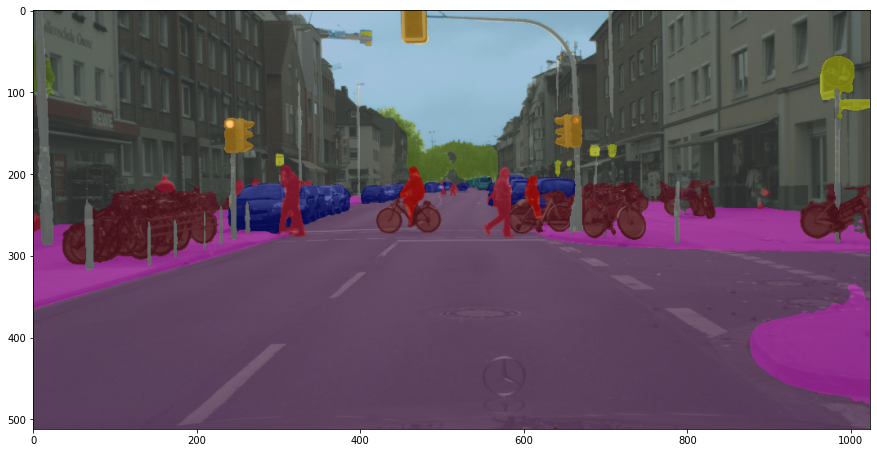

In [ ]:
# show the results
show_result_pyplot(model, img, result, get_palette('cityscapes'))